# 0. Define the EnFK function
This defines the original EnKF for non-linear systems. \\
Note that `process_model` and `observation_model` are problem dependent. \\
The function defined here is for $y$ being a real value (1 dim).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class EnsembleKalmanFilter:
    def __init__(self, ensemble_size, state_dim, process_model, observation_model, R, Q):
        self.ensemble_size = ensemble_size
        self.state_dim = state_dim
        self.process_model = process_model
        self.observation_model = observation_model
        self.R = R  # Observation noise covariance
        self.Q = Q  # Process noise covariance
        self.ensemble = None

    def initialize_ensemble(self, initial_state, spread=1.0):
        """
        Initializes the ensemble with a given initial state and spread.
        :param initial_state: Initial state vector (numpy array)
        :param spread: Initial spread for random perturbations
        """
        self.ensemble = np.array([initial_state + spread * np.random.randn(self.state_dim) for _ in range(self.ensemble_size)])

    def predict(self):
        """
        Forcast step
        Apply the process model to predict the next state for each ensemble member.
        """
        for i in range(self.ensemble_size):
            process_noise = np.random.multivariate_normal(np.zeros(self.state_dim), self.Q)
            self.ensemble[i] = self.process_model(self.ensemble[i]) + process_noise

    def update(self, observation):
        """
        Analysis step
        Update the ensemble based on the observation.
        :param observation: Observation vector (numpy array)
        """
        # Compute ensemble mean and observation mean
        ensemble_mean = np.mean(self.ensemble, axis=0)
        ensemble_observations = np.array([self.observation_model(member) for member in self.ensemble])
        observation_mean = np.mean(ensemble_observations, axis=0)

        # Compute innovation covariance and Kalman gain
        # y is 1-dim in the first example
        P_yy = np.cov(ensemble_observations, rowvar=False) + self.R
        P_xy = np.cov(self.ensemble.T, ensemble_observations.T)[:self.state_dim, self.state_dim:].reshape(2,)
        K = P_xy * (1/P_yy)

        # Update each ensemble member
        for i in range(self.ensemble_size):
            innovation = observation + np.random.normal(0, self.R) - ensemble_observations[i]
            self.ensemble[i] += K * innovation

    def get_state_estimate(self):
        """
        Returns the current state estimate (mean of the ensemble).
        """
        return np.mean(self.ensemble, axis=0)

# Example 1: Van der Pol Oscillator from gillijns2006ensemble
Here, I first try the original EnKF with different ensemble sizes. \\
This is a low-order example.

## 1.1. Define processes for the problem

In [ ]:
# State transition function for Van der Pol oscillator
# The models are without noises
def process_model(state):
    x1, x2 = state
    dx1 = x1 + h * x2
    dx2 = x2 + h * (alpha * (1 - x1**2) * x2 - x1)
    return np.array([dx1, dx2])

def observation_model(state):
    return C @ state

## 1.2. Define parameters and Generate data
Set the ensemble size to be 5 for later analysis.

In [ ]:
# Define parameters
np.random.seed(123)
ensemble_size = 5
state_dim = 2
R = 0.003  # Observation noise covariance
Q = np.diag([0.0262, 0.008])  # Process noise covariance
alpha = 1.0  # Parameter for the Van der Pol oscillator
h = 0.1      # Step size
C = np.array([0, 1])
T = 500  # Total time steps
initial_state = np.zeros(state_dim)


# Instantiate and initialize EnKF
enkf = EnsembleKalmanFilter(ensemble_size, state_dim, process_model, observation_model, R, Q)
enkf.initialize_ensemble(initial_state)

# Generate data and the true states
w = np.random.multivariate_normal(np.zeros(state_dim), Q)
true_states = np.array([process_model(initial_state) + w])
v = np.random.normal(0, R)
observations = np.array([observation_model(true_states[0,])+ v])

for t in range(T):
    w = np.random.multivariate_normal(np.zeros(state_dim), Q)
    true_state = process_model(true_states[t,]) + w
    true_states = np.append(true_states, [true_state], axis=0)
    if t+1 == T:
        break
    v = np.random.normal(0, R)
    observation = observation_model(true_states[t+1]) + v
    observations = np.append(observations, [observation], axis=0)

print("True states shape", np.shape(true_states))
print("Observations shape", np.shape(observations))

True states shape (501, 2)
Observations shape (500,)


## 1.3. Implement and visualize the original EnKF with ensemble sizes (5, 10, 30)
Increasing the number of ensemble members seems to improve the performance. \\
Result of $x_1$ very sensitive to random seed.


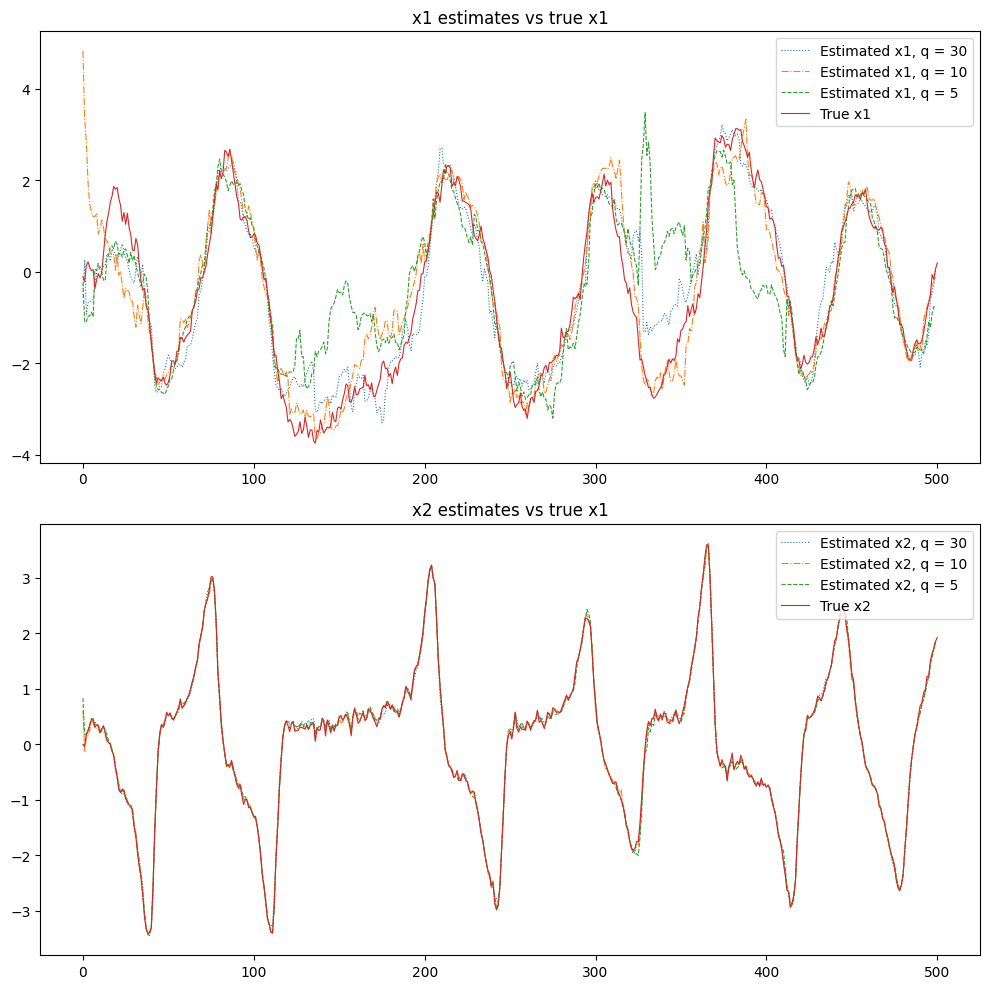

In [ ]:
# Implement the EnFK
np.random.seed(123)
ensemble_size = 30
result_x1_30 = []
result_x2_30 = []
for observation in observations:
  enkf.predict()
  enkf.update(observation)
  result_x1_30.append(enkf.get_state_estimate()[0])
  result_x2_30.append(enkf.get_state_estimate()[1])

ensemble_size = 10
result_x1_10 = []
result_x2_10 = []
for observation in observations:
  enkf.predict()
  enkf.update(observation)
  result_x1_10.append(enkf.get_state_estimate()[0])
  result_x2_10.append(enkf.get_state_estimate()[1])

ensemble_size = 5
result_x1 = []
result_x2 = []
for observation in observations:
  enkf.predict()
  enkf.update(observation)
  result_x1.append(enkf.get_state_estimate()[0])
  result_x2.append(enkf.get_state_estimate()[1])

# Visualize
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot data in each subplot
axs[0].plot(result_x1_30, linestyle=':', linewidth=0.8, label="Estimated x1, q = 30")
axs[0].plot(result_x1_10, linestyle='-.', linewidth=0.8, label="Estimated x1, q = 10")
axs[0].plot(result_x1, linestyle='--', linewidth=0.8, label="Estimated x1, q = 5")
axs[0].plot(true_states[:, 0], linewidth=0.8, label="True x1")
axs[0].set_title("x1 estimates vs true x1")
axs[0].legend()

axs[1].plot(result_x2_30, linestyle=':', linewidth=0.8, label="Estimated x2, q = 30")
axs[1].plot(result_x2_10, linestyle='-.', linewidth=0.8, label="Estimated x2, q = 10")
axs[1].plot(result_x2, linestyle='--', linewidth=0.8, label="Estimated x2, q = 5")
axs[1].plot(true_states[:, 1], linewidth=0.8, label="True x2")
axs[1].set_title("x2 estimates vs true x1")
axs[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## 1.4. Use $2R$ in the EnFK and compare the result from $R$, $q = 30$


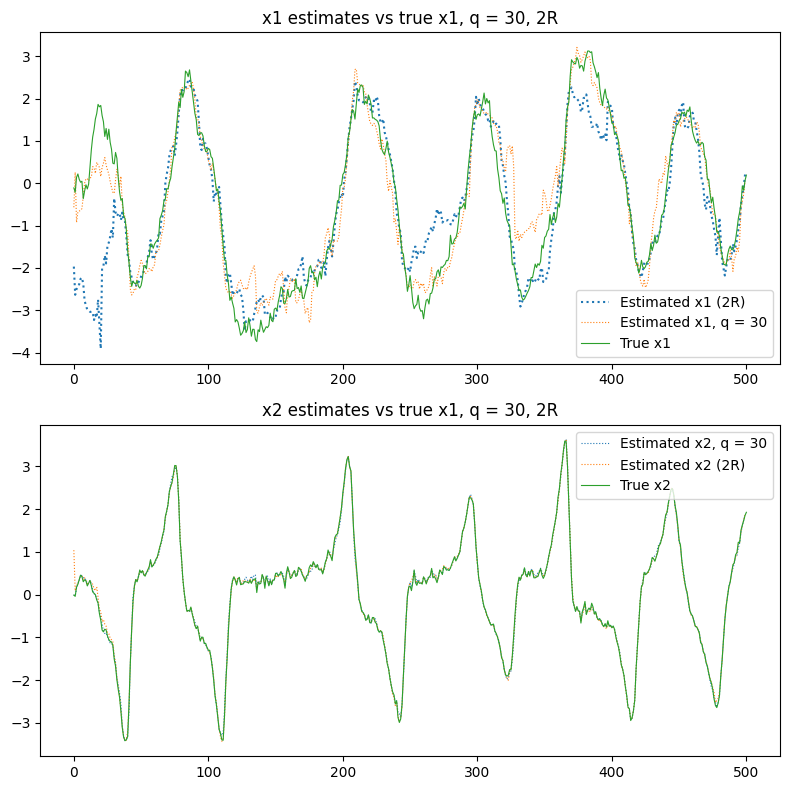

In [ ]:
R = 0.003*2  # Observation noise covariance
ensemble_size = 30
result_x1_two = []
result_x2_two = []
for observation in observations:
  enkf.predict()
  enkf.update(observation)
  result_x1_two.append(enkf.get_state_estimate()[0])
  result_x2_two.append(enkf.get_state_estimate()[1])

# Visualize
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

# Plot data in each subplot
axs[0].plot(result_x1_two, linestyle=':', label="Estimated x1 (2R)")
axs[0].plot(result_x1_30, linestyle=':', linewidth=0.8, label="Estimated x1, q = 30")
axs[0].plot(true_states[:, 0], linewidth=0.8, label="True x1")
axs[0].set_title("x1 estimates vs true x1, q = 30, 2R")
axs[0].legend()

axs[1].plot(result_x2_30, linestyle=':', linewidth=0.8, label="Estimated x2, q = 30")
axs[1].plot(result_x2_two, linestyle=':', linewidth=0.8, label="Estimated x2 (2R)")
axs[1].plot(true_states[:, 1], linewidth=0.8, label="True x2")
axs[1].set_title("x2 estimates vs true x1, q = 30, 2R")
axs[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Compute MSEs for $x_1$ and $x_2$.

In [ ]:
# For 2R
MSE_x1_two = np.mean((np.array(result_x1_two) - true_states[1:, 0])**2)
MSE_x2_two = np.mean((np.array(result_x2_two) - true_states[1:, 1])**2)
print(f"MSE x1 (2R): {MSE_x1_two:.2}")
print(f"MSE x2 (2R): {MSE_x2_two:.2}")

# For R
MSE_x1 = np.mean((np.array(result_x1_30) - true_states[1:, 0])**2)
MSE_x2 = np.mean((np.array(result_x2_30) - true_states[1:, 1])**2)
print(f"MSE x1: {MSE_x1:.2}")
print(f"MSE x2: {MSE_x2:.2}")

MSE x1 (2R): 0.99
MSE x2 (2R): 0.059
MSE x1: 0.39
MSE x2: 0.056


# Example 2. Ornstein-Uhlenbeck model from sarkka2019applied example 10.19
Linear and low dimension case. \\

**Example 10.19 (Kalman filter for the Ornstein-Uhlenbeck model).** $R e$ call from Example 6.2 that the equivalent discretization of the OrnsteinUhlenbeck model is

$$
\begin{aligned}
x\left(t_{k+1}\right) & =a_k x\left(t_k\right)+q_k, \\
y_k & =x\left(t_k\right)+r_k,
\end{aligned}
$$

with $q_k \sim \mathrm{~N}\left(0, \Sigma_k\right), r_k \sim \mathrm{~N}(0, R), a_k=\exp \left(-\lambda \Delta t_k\right)$, and $\Sigma_k=\frac{q}{2 \lambda}[1-$ $\left.\exp \left(-2 \lambda \Delta t_k\right)\right]$.

Kalman Filter MSE: 0.026
Ensemble Kalman Filter MSE: 0.035
Ensemble Kalman Filter with R=2R MSE: 0.038


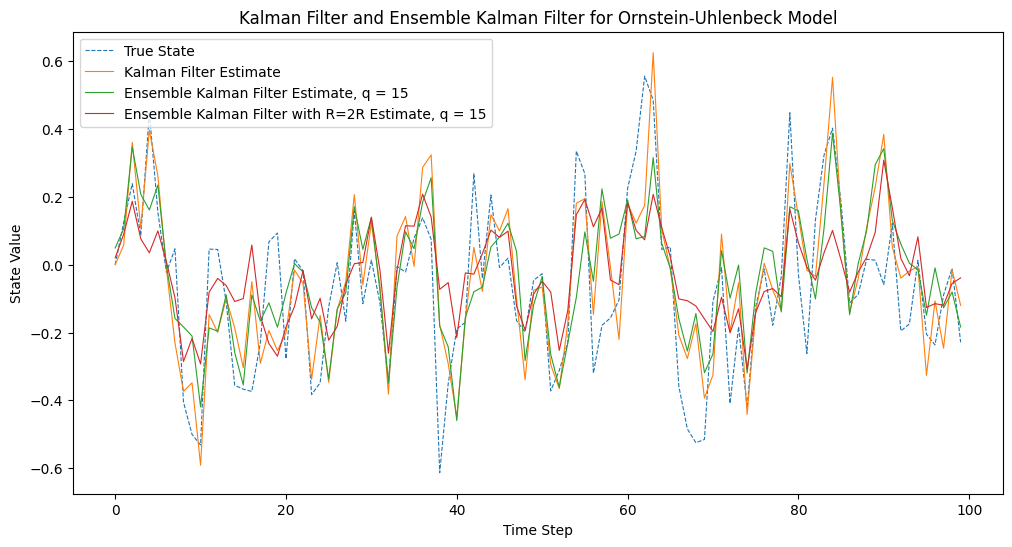

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Define parameters for the Ornstein-Uhlenbeck process
lambda_ = 0.5
q = 0.1
R = 0.05
initial_mean = 0.0
initial_variance = 1.0
num_steps = 100
ensemble_size = 15

dt = 1.0  # Time step

a_k = np.exp(-lambda_ * dt)
Sigma_k = (q / (2 * lambda_)) * (1 - np.exp(-2 * lambda_ * dt))

# Generate synthetic observations
y = [initial_mean]
true_state = [initial_mean]

for _ in range(1, num_steps):
    process_noise = np.random.normal(0, np.sqrt(Sigma_k))
    next_state = a_k * true_state[-1] + process_noise
    observation_noise = np.random.normal(0, np.sqrt(R))
    observation = next_state + observation_noise
    true_state.append(next_state)
    y.append(observation)

# Apply the Kalman Filter
m_k = initial_mean
P_k = initial_variance

state_estimates = []
for k in range(num_steps):
    # Predict step
    m_k_minus = np.exp(-lambda_ * dt) * m_k
    P_k_minus = np.exp(-2 * lambda_ * dt) * P_k + (q / (2 * lambda_)) * (1 - np.exp(-2 * lambda_ * dt))

    # Update step
    y_k = y[k]
    K_k = P_k_minus / (P_k_minus + R)
    m_k = m_k_minus + K_k * (y_k - m_k_minus)
    P_k = P_k_minus - (K_k ** 2) * (P_k_minus + R)

    state_estimates.append(m_k)

# Apply the Ensemble Kalman Filter
ensemble = np.random.normal(initial_mean, np.sqrt(initial_variance), ensemble_size)
enkf_estimates = []

for k in range(num_steps):
    # Predict step
    ensemble = a_k * ensemble + np.random.normal(0, np.sqrt(Sigma_k), ensemble_size)

    # Update step
    observation_noise = np.random.normal(0, np.sqrt(R), ensemble_size)
    ensemble_observations = ensemble + observation_noise
    ensemble_mean = np.mean(ensemble)
    obs_mean = np.mean(ensemble_observations)
    cov_xy = np.cov(ensemble, ensemble_observations, bias=True)[0, 1]
    var_y = np.var(ensemble_observations, ddof=0)
    K_k = cov_xy / (var_y + R)
    ensemble += K_k * (y[k] - ensemble_observations)

    enkf_estimates.append(np.mean(ensemble))

# Apply the Ensemble Kalman Filter with R = 2R
R_2 = 2 * R
ensemble_2R = np.random.normal(initial_mean, np.sqrt(initial_variance), ensemble_size)
enkf_2R_estimates = []

for k in range(num_steps):
    # Predict step
    ensemble_2R = a_k * ensemble_2R + np.random.normal(0, np.sqrt(Sigma_k), ensemble_size)

    # Update step
    observation_noise = np.random.normal(0, np.sqrt(R_2), ensemble_size)
    ensemble_observations = ensemble_2R + observation_noise
    ensemble_mean = np.mean(ensemble_2R)
    obs_mean = np.mean(ensemble_observations)
    cov_xy = np.cov(ensemble_2R, ensemble_observations, bias=True)[0, 1]
    var_y = np.var(ensemble_observations, ddof=0)
    K_k = cov_xy / (var_y + R_2)
    ensemble_2R += K_k * (y[k] - ensemble_observations)

    enkf_2R_estimates.append(np.mean(ensemble_2R))

# Compute Mean Squared Errors (MSE)
def compute_mse(true_values, estimated_values):
    return np.mean((np.array(true_values) - np.array(estimated_values)) ** 2)

kf_mse = compute_mse(true_state, state_estimates)
enkf_mse = compute_mse(true_state, enkf_estimates)
enkf_2R_mse = compute_mse(true_state, enkf_2R_estimates)

print(f"Kalman Filter MSE: {kf_mse:.2}")
print(f"Ensemble Kalman Filter MSE: {enkf_mse:.2}")
print(f"Ensemble Kalman Filter with R=2R MSE: {enkf_2R_mse:.2}")

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(range(num_steps), true_state, linewidth=0.8, label='True State', linestyle='--')
# plt.plot(range(num_steps), y, label='Observations', linestyle=':')
plt.plot(range(num_steps), state_estimates, linewidth=0.8, label='Kalman Filter Estimate')
plt.plot(range(num_steps), enkf_estimates, linewidth=0.8, label='Ensemble Kalman Filter Estimate, q = 15')
plt.plot(range(num_steps), enkf_2R_estimates, linewidth=0.8, label='Ensemble Kalman Filter with R=2R Estimate, q = 15')
plt.xlabel('Time Step')
plt.ylabel('State Value')
plt.title('Kalman Filter and Ensemble Kalman Filter for Ornstein-Uhlenbeck Model')
plt.legend()
plt.show()
